# IF702 Redes Neurais
Projeto de redes neurais utilizando Base de Dados do Tipo 2, Detecção de Células de Câncer em Mamografias

In [1]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_auc_score

import matplotlib
matplotlib.use('nbagg')
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Leitura e Limpeza dos Dados

Para a leitura da base de dados foi feita utilizando a biblioteca pandas.

In [2]:
data_set = pd.read_csv('mammography.csv')

data_set.columns = ['X1','X2','X3','X4','X5','X6','CLASS'] # renomeando as colunas para ficar CLASS em vez de class

### Removendo exemplos repetidos

In [3]:
columns = data_set.columns.tolist()[:-1] # remove a coluna da classe da lista de colunas
# print (columns)
data_set.drop_duplicates(subset=columns, # seleciona apenas as 6 primeiras colunas para verificar duplicatas
                         keep=False, # remove todos os exemplos repetidos
                         inplace=True)  # Remove exemplos repetidos
print (len(data_set))

7845


### Renomeando a classe -1 para 0

In [4]:
data_set['CLASS'] = data_set['CLASS'].map(lambda x : 0 if (x == -1) else 1)
# print (data_set)

Estatisticas da base de dados

In [5]:
# Estatísticas sobre as variáveis
data_set.describe()

,X1,X2,X3,X4,X5,X6,CLASS
count,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000,7845.000000
mean,0.333764,0.200042,0.251736,0.365734,0.160780,0.402400,0.032250
std,1.025813,1.136427,1.101461,0.988616,1.157123,0.939678,0.176674
min,-0.784415,-0.452501,-0.591631,-0.859553,-0.377866,-0.945723,0.000000
25%,-0.145333,-0.408265,-0.276061,-0.859553,-0.377866,-0.945723,0.000000
50%,0.111790,-0.271133,-0.005571,0.550163,-0.377866,0.845975,0.000000
75%,0.508993,0.219887,0.400163,1.027382,0.387549,1.132403,0.000000
max,31.508443,5.085849,29.477769,9.591164,23.617122,1.949027,1.000000


### Separando as classes da base de dados

Criando função para separando a base de dados pelas classes, para assim poder garantir que vai ter exemplos de cada classe em todos os conjuntos

In [6]:
def separar_classes(data):
    zero = data[data.CLASS == 0]
    um = data[data.CLASS == 1]
    
    return [zero, um]

# print (len(separar_grupos(data_set)[0]))

### Divisão dos Dados em Treino, Validação, e Teste

In [7]:
def separar_grupos_tvt(data): 
    """
    Divisão da base de dados
    Treinamento = 50%
    Validação = 25%
    Teste = 25%
    """
    
    # classe zero
    zero_train, zero_validation = train_test_split(data[0], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    zero_validation, zero_teste = train_test_split(zero_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    #classe um
    um_train, um_validation = train_test_split(data[1], # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    um_validation, um_teste = train_test_split(um_validation, # base de dados que vai ser dividida
                                                   test_size=1/2, # proporção da divisão dos dados
                                                   random_state=42)
    
    return [(zero_train, zero_validation, zero_teste),(um_train, um_validation, um_teste)]

### Oversampling dos dados

Replicando os dados da classe minoritaria para ter a mesma quantidade de exemplos das duas classes na MLP.

In [8]:
def oversampling(data):
    um_train = data[1][0]
    um_validation = data[1][1]
    um_train = np.resize(um_train, data[0][0].shape)
    um_validation = np.resize(um_validation, data[0][1].shape)
    
    return [data[0],(um_train, um_validation, data[1][2])]

### Juntando as classes

Juntando as classes zero e um dos conjuntos de treinamento, validação e teste

In [9]:
def join_class(data):
    train = np.concatenate((data[0][0], data[1][0]), axis=0)
    validation = np.concatenate((data[0][1], data[1][1]), axis=0)
    test = np.concatenate((data[0][2], data[1][2]), axis=0)

    np.random.shuffle(train)
    np.random.shuffle(validation)
    np.random.shuffle(test)
    
    return [train, validation, test]

In [10]:
# data_set_oversampling = oversampling(separar_grupos_tvt(separar_classes(data_set)))
# print (data_set_oversampling)
sep = separar_classes(data_set)
print (len(sep[0]), len(sep[1]))
grupos = separar_grupos_tvt(sep)
print (len(grupos[0][0]), len(grupos[0][1]), len(grupos[0][2]), 
       len(grupos[1][0]), len(grupos[1][1]), len(grupos[1][2]))
over = oversampling(grupos)
print (len(over[0][0]), len(over[0][1]), len(over[0][2]), 
       len(over[1][0]), len(over[1][1]), len(over[1][2]))

join_c = join_class(over)
print (len(join_c[0]), len(join_c[1]), len(join_c[2]))

7592 253
3796 1898 1898 126 63 64
3796 1898 1898 3796 1898 64
7592 3796 1962


### Separando entrada de saida

In [11]:
# columns = data_set.columns.tolist()
# shape_view = data_set.reindex(columns=columns[1:10] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
# rgb_view = data_set.reindex(columns=columns[10:] + [columns[0]]) # columns[0] é a coluna que fica qual é a classe que o exemplo pertence
X_train = join_c[0][:,:-1]
y_train = join_c[0][:,-1]

X_validation = join_c[1][:,:-1]
y_validation = join_c[1][:,-1]

X_test = join_c[2][:,:-1]
y_test = join_c[2][:,-1]
# print (y_validation)


# utilizado para verificar a quantidade de exemplos de cada classe que tem nos conjuntos de validação, teste e treinamento
import collections
print (collections.Counter(y_train))
print (collections.Counter(y_validation))
print (collections.Counter(y_test))

Counter({0.0: 3796, 1.0: 3796})
Counter({0.0: 1898, 1.0: 1898})
Counter({0.0: 1898, 1.0: 64})


### Normalização dos dados

In [12]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

## Definição e Treino da Rede

Algumas funções auxiliares.

In [13]:
def extract_final_losses(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    idx_min_val_loss = np.argmin(val_loss)
    
    return {'train_loss': train_loss[idx_min_val_loss], 'val_loss': val_loss[idx_min_val_loss]}

def plot_training_error_curves(history):
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Error Curves', xlabel='Epochs', ylabel='Loss (MSE)')
    ax.legend()
    plt.show()
    
def plot_training_acc_curves(history):
    train_loss = history.history['acc']
    val_loss = history.history['val_acc']
    
    fig, ax = plt.subplots()
    ax.plot(train_loss, label='Train')
    ax.plot(val_loss, label='Validation')
    ax.set(title='Training and Validation Accuracy Curves', xlabel='Epochs', ylabel='Accuracy')
    ax.legend()
    plt.show()
    

## RNA 1 (3)

In [14]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=2000, # quantidade de epocas que a rede neural vai executar
                         verbose=1,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

Train on 7592 samples, validate on 3796 samples
Epoch 1/2000
7592/7592 [==============================] - 0s - loss: 0.5185 - acc: 0.4893 - val_loss: 0.5029 - val_acc: 0.4979
Epoch 2/2000
7592/7592 [==============================] - 0s - loss: 0.5028 - acc: 0.4957 - val_loss: 0.4989 - val_acc: 0.4995
Epoch 3/2000
7592/7592 [==============================] - 0s - loss: 0.3612 - acc: 0.5802 - val_loss: 0.2178 - val_acc: 0.7039
Epoch 4/2000
7592/7592 [==============================] - 0s - loss: 0.1634 - acc: 0.7923 - val_loss: 0.1924 - val_acc: 0.7979
Epoch 5/2000
7592/7592 [==============================] - 0s - loss: 0.1255 - acc: 0.8585 - val_loss: 0.1901 - val_acc: 0.8314
Epoch 6/2000
7592/7592 [==============================] - 0s - loss: 0.1115 - acc: 0.8736 - val_loss: 0.1682 - val_acc: 0.8612
Epoch 7/2000
7592/7592 [==============================] - 0s - loss: 0.1047 - acc: 0.8892 - val_loss: 0.1667 - val_acc: 0.8680
Epoch 8/2000
7592/7592 [==============================] - 0s - 

7592/7592 [==============================] - 0s - loss: 0.0751 - acc: 0.9073 - val_loss: 0.0903 - val_acc: 0.9002
Epoch 65/2000
7592/7592 [==============================] - 0s - loss: 0.0750 - acc: 0.9085 - val_loss: 0.0895 - val_acc: 0.8973
Epoch 66/2000
7592/7592 [==============================] - 0s - loss: 0.0751 - acc: 0.9073 - val_loss: 0.0901 - val_acc: 0.8923
Epoch 67/2000
7592/7592 [==============================] - 0s - loss: 0.0751 - acc: 0.9081 - val_loss: 0.0909 - val_acc: 0.8938
Epoch 68/2000
7592/7592 [==============================] - 0s - loss: 0.0750 - acc: 0.9081 - val_loss: 0.0920 - val_acc: 0.8867
Epoch 69/2000
7592/7592 [==============================] - 0s - loss: 0.0750 - acc: 0.9092 - val_loss: 0.0894 - val_acc: 0.8988
Epoch 70/2000
7592/7592 [==============================] - 0s - loss: 0.0750 - acc: 0.9078 - val_loss: 0.0901 - val_acc: 0.8946
Epoch 71/2000
7592/7592 [==============================] - 0s - loss: 0.0750 - acc: 0.9069 - val_loss: 0.0899 - val_ac

7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9063 - val_loss: 0.0905 - val_acc: 0.8944
Epoch 128/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9048 - val_loss: 0.0901 - val_acc: 0.8917
Epoch 129/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9046 - val_loss: 0.0927 - val_acc: 0.8894
Epoch 130/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9062 - val_loss: 0.0902 - val_acc: 0.8936
Epoch 131/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9052 - val_loss: 0.0907 - val_acc: 0.8928
Epoch 132/2000
7592/7592 [==============================] - 0s - loss: 0.0748 - acc: 0.9046 - val_loss: 0.0909 - val_acc: 0.8938
Epoch 133/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9049 - val_loss: 0.0905 - val_acc: 0.8933
Epoch 134/2000
7592/7592 [==============================] - 0s - loss: 0.0748 - acc: 0.9040 - val_loss: 0.0913 -

7592/7592 [==============================] - 0s - loss: 0.0746 - acc: 0.9044 - val_loss: 0.0900 - val_acc: 0.8994
Epoch 191/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9042 - val_loss: 0.0910 - val_acc: 0.8870
Epoch 192/2000
7592/7592 [==============================] - 0s - loss: 0.0746 - acc: 0.9046 - val_loss: 0.0905 - val_acc: 0.8949
Epoch 193/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9041 - val_loss: 0.0901 - val_acc: 0.8944
Epoch 194/2000
7592/7592 [==============================] - 0s - loss: 0.0745 - acc: 0.9060 - val_loss: 0.0892 - val_acc: 0.8973
Epoch 195/2000
7592/7592 [==============================] - 0s - loss: 0.0746 - acc: 0.9049 - val_loss: 0.0905 - val_acc: 0.8930
Epoch 196/2000
7592/7592 [==============================] - 0s - loss: 0.0747 - acc: 0.9052 - val_loss: 0.0902 - val_acc: 0.9002
Epoch 197/2000
7592/7592 [==============================] - 0s - loss: 0.0746 - acc: 0.9057 - val_loss: 0.0893 -

7592/7592 [==============================] - 0s - loss: 0.0742 - acc: 0.9070 - val_loss: 0.0917 - val_acc: 0.8862
Epoch 254/2000
7592/7592 [==============================] - 0s - loss: 0.0742 - acc: 0.9065 - val_loss: 0.0920 - val_acc: 0.8936
Epoch 255/2000
7592/7592 [==============================] - 0s - loss: 0.0743 - acc: 0.9069 - val_loss: 0.0915 - val_acc: 0.8870
Epoch 256/2000
7592/7592 [==============================] - 0s - loss: 0.0742 - acc: 0.9054 - val_loss: 0.0913 - val_acc: 0.8954
Epoch 257/2000
7592/7592 [==============================] - 0s - loss: 0.0743 - acc: 0.9063 - val_loss: 0.0902 - val_acc: 0.8925
Epoch 258/2000
7592/7592 [==============================] - 0s - loss: 0.0743 - acc: 0.9050 - val_loss: 0.0907 - val_acc: 0.8925
Epoch 259/2000
7592/7592 [==============================] - 0s - loss: 0.0742 - acc: 0.9078 - val_loss: 0.0917 - val_acc: 0.8872
Epoch 260/2000
7592/7592 [==============================] - 0s - loss: 0.0742 - acc: 0.9053 - val_loss: 0.0907 -

7592/7592 [==============================] - 0s - loss: 0.0727 - acc: 0.9114 - val_loss: 0.0894 - val_acc: 0.8917
Epoch 317/2000
7592/7592 [==============================] - 0s - loss: 0.0727 - acc: 0.9103 - val_loss: 0.0901 - val_acc: 0.8944
Epoch 318/2000
7592/7592 [==============================] - 0s - loss: 0.0727 - acc: 0.9108 - val_loss: 0.0897 - val_acc: 0.8936
Epoch 319/2000
7592/7592 [==============================] - 0s - loss: 0.0727 - acc: 0.9107 - val_loss: 0.0893 - val_acc: 0.8933
Epoch 320/2000
7592/7592 [==============================] - 0s - loss: 0.0727 - acc: 0.9111 - val_loss: 0.0901 - val_acc: 0.8941
Epoch 321/2000
7592/7592 [==============================] - 0s - loss: 0.0727 - acc: 0.9110 - val_loss: 0.0896 - val_acc: 0.8925
Epoch 322/2000
7592/7592 [==============================] - 0s - loss: 0.0726 - acc: 0.9114 - val_loss: 0.0892 - val_acc: 0.8901
Epoch 323/2000
7592/7592 [==============================] - 0s - loss: 0.0726 - acc: 0.9116 - val_loss: 0.0894 -

7592/7592 [==============================] - 0s - loss: 0.0708 - acc: 0.9154 - val_loss: 0.0945 - val_acc: 0.8949
Epoch 380/2000
7592/7592 [==============================] - 0s - loss: 0.0708 - acc: 0.9181 - val_loss: 0.0948 - val_acc: 0.8954
Epoch 381/2000
7592/7592 [==============================] - 0s - loss: 0.0708 - acc: 0.9161 - val_loss: 0.0951 - val_acc: 0.8891
Epoch 382/2000
7592/7592 [==============================] - 0s - loss: 0.0707 - acc: 0.9165 - val_loss: 0.0946 - val_acc: 0.8957
Epoch 383/2000
7592/7592 [==============================] - 0s - loss: 0.0707 - acc: 0.9161 - val_loss: 0.0956 - val_acc: 0.8888
Epoch 384/2000
7592/7592 [==============================] - 0s - loss: 0.0706 - acc: 0.9170 - val_loss: 0.0949 - val_acc: 0.8925
Epoch 385/2000
7592/7592 [==============================] - 0s - loss: 0.0706 - acc: 0.9144 - val_loss: 0.0950 - val_acc: 0.8941
Epoch 386/2000
7592/7592 [==============================] - 0s - loss: 0.0706 - acc: 0.9179 - val_loss: 0.0948 -

7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9168 - val_loss: 0.0961 - val_acc: 0.8862
Epoch 443/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9146 - val_loss: 0.0962 - val_acc: 0.8933
Epoch 444/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9144 - val_loss: 0.0968 - val_acc: 0.8894
Epoch 445/2000
7592/7592 [==============================] - 0s - loss: 0.0700 - acc: 0.9141 - val_loss: 0.0971 - val_acc: 0.8886
Epoch 446/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9141 - val_loss: 0.0970 - val_acc: 0.8875
Epoch 447/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9154 - val_loss: 0.0968 - val_acc: 0.8875
Epoch 448/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9153 - val_loss: 0.0970 - val_acc: 0.8851
Epoch 449/2000
7592/7592 [==============================] - 0s - loss: 0.0699 - acc: 0.9144 - val_loss: 0.0970 -

7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9144 - val_loss: 0.0975 - val_acc: 0.8854
Epoch 506/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9146 - val_loss: 0.0971 - val_acc: 0.8899
Epoch 507/2000
7592/7592 [==============================] - 0s - loss: 0.0697 - acc: 0.9157 - val_loss: 0.0983 - val_acc: 0.8804
Epoch 508/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9145 - val_loss: 0.0988 - val_acc: 0.8815
Epoch 509/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9150 - val_loss: 0.0979 - val_acc: 0.8854
Epoch 510/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9143 - val_loss: 0.0978 - val_acc: 0.8812
Epoch 511/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9146 - val_loss: 0.0982 - val_acc: 0.8815
Epoch 512/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9154 - val_loss: 0.0993 -

7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9152 - val_loss: 0.0982 - val_acc: 0.8772
Epoch 569/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9174 - val_loss: 0.0986 - val_acc: 0.8791
Epoch 570/2000
7592/7592 [==============================] - 0s - loss: 0.0696 - acc: 0.9139 - val_loss: 0.0985 - val_acc: 0.8801
Epoch 571/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9143 - val_loss: 0.0991 - val_acc: 0.8804
Epoch 572/2000
7592/7592 [==============================] - 0s - loss: 0.0695 - acc: 0.9152 - val_loss: 0.0990 - val_acc: 0.8812
Epoch 573/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9146 - val_loss: 0.0986 - val_acc: 0.8791
Epoch 574/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9145 - val_loss: 0.0986 - val_acc: 0.8772
Epoch 575/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9150 - val_loss: 0.0992 -

7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9157 - val_loss: 0.0990 - val_acc: 0.8783
Epoch 632/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9158 - val_loss: 0.0993 - val_acc: 0.8778
Epoch 633/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9160 - val_loss: 0.0992 - val_acc: 0.8791
Epoch 634/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9146 - val_loss: 0.0994 - val_acc: 0.8801
Epoch 635/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9145 - val_loss: 0.0985 - val_acc: 0.8767
Epoch 636/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9154 - val_loss: 0.0992 - val_acc: 0.8791
Epoch 637/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9148 - val_loss: 0.1000 - val_acc: 0.8809
Epoch 638/2000
7592/7592 [==============================] - 0s - loss: 0.0694 - acc: 0.9150 - val_loss: 0.1004 -

7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9148 - val_loss: 0.0989 - val_acc: 0.8762
Epoch 695/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9146 - val_loss: 0.1011 - val_acc: 0.8807
Epoch 696/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9153 - val_loss: 0.0999 - val_acc: 0.8815
Epoch 697/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9148 - val_loss: 0.1010 - val_acc: 0.8833
Epoch 698/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9146 - val_loss: 0.0997 - val_acc: 0.8786
Epoch 699/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9153 - val_loss: 0.1000 - val_acc: 0.8778
Epoch 700/2000
7592/7592 [==============================] - 0s - loss: 0.0693 - acc: 0.9164 - val_loss: 0.0991 - val_acc: 0.8770
Epoch 701/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9153 - val_loss: 0.0996 -

7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9154 - val_loss: 0.1004 - val_acc: 0.8815
Epoch 758/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9165 - val_loss: 0.0997 - val_acc: 0.8804
Epoch 759/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9153 - val_loss: 0.0996 - val_acc: 0.8775
Epoch 760/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9158 - val_loss: 0.1008 - val_acc: 0.8812
Epoch 761/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9164 - val_loss: 0.1000 - val_acc: 0.8788
Epoch 762/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9153 - val_loss: 0.0995 - val_acc: 0.8778
Epoch 763/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9158 - val_loss: 0.0998 - val_acc: 0.8804
Epoch 764/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9143 - val_loss: 0.1003 -

7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9156 - val_loss: 0.1003 - val_acc: 0.8807
Epoch 821/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9157 - val_loss: 0.1007 - val_acc: 0.8815
Epoch 822/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9162 - val_loss: 0.1015 - val_acc: 0.8820
Epoch 823/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9169 - val_loss: 0.1003 - val_acc: 0.8772
Epoch 824/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9177 - val_loss: 0.1005 - val_acc: 0.8804
Epoch 825/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9160 - val_loss: 0.1003 - val_acc: 0.8820
Epoch 826/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9178 - val_loss: 0.0998 - val_acc: 0.8783
Epoch 827/2000
7592/7592 [==============================] - 0s - loss: 0.0692 - acc: 0.9165 - val_loss: 0.1006 -

7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9161 - val_loss: 0.1002 - val_acc: 0.8791
Epoch 884/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9175 - val_loss: 0.1001 - val_acc: 0.8783
Epoch 885/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9177 - val_loss: 0.1003 - val_acc: 0.8851
Epoch 886/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9165 - val_loss: 0.1014 - val_acc: 0.8817
Epoch 887/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9161 - val_loss: 0.0999 - val_acc: 0.8841
Epoch 888/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9175 - val_loss: 0.1002 - val_acc: 0.8854
Epoch 889/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9160 - val_loss: 0.1002 - val_acc: 0.8801
Epoch 890/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9175 - val_loss: 0.1009 -

7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9161 - val_loss: 0.1017 - val_acc: 0.8830
Epoch 947/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9177 - val_loss: 0.0997 - val_acc: 0.8867
Epoch 948/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9166 - val_loss: 0.1000 - val_acc: 0.8854
Epoch 949/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9175 - val_loss: 0.1003 - val_acc: 0.8815
Epoch 950/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9161 - val_loss: 0.1005 - val_acc: 0.8859
Epoch 951/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9171 - val_loss: 0.1008 - val_acc: 0.8872
Epoch 952/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9178 - val_loss: 0.1005 - val_acc: 0.8854
Epoch 953/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9158 - val_loss: 0.1003 -

7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9174 - val_loss: 0.1003 - val_acc: 0.8872
Epoch 1010/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9189 - val_loss: 0.1017 - val_acc: 0.8820
Epoch 1011/2000
7592/7592 [==============================] - 0s - loss: 0.0691 - acc: 0.9170 - val_loss: 0.1004 - val_acc: 0.8822
Epoch 1012/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9178 - val_loss: 0.0998 - val_acc: 0.8862
Epoch 1013/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9171 - val_loss: 0.1002 - val_acc: 0.8880
Epoch 1014/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9168 - val_loss: 0.0996 - val_acc: 0.8851
Epoch 1015/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9174 - val_loss: 0.1000 - val_acc: 0.8888
Epoch 1016/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9175 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9175 - val_loss: 0.0996 - val_acc: 0.8865
Epoch 1072/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9149 - val_loss: 0.0998 - val_acc: 0.8888
Epoch 1073/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9182 - val_loss: 0.0996 - val_acc: 0.8917
Epoch 1074/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9166 - val_loss: 0.0995 - val_acc: 0.8849
Epoch 1075/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9168 - val_loss: 0.1008 - val_acc: 0.8894
Epoch 1076/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9190 - val_loss: 0.0998 - val_acc: 0.8859
Epoch 1077/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9169 - val_loss: 0.1002 - val_acc: 0.8854
Epoch 1078/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9185 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9171 - val_loss: 0.0996 - val_acc: 0.8854
Epoch 1135/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9177 - val_loss: 0.1005 - val_acc: 0.8901
Epoch 1136/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9160 - val_loss: 0.1001 - val_acc: 0.8888
Epoch 1137/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9162 - val_loss: 0.1006 - val_acc: 0.8891
Epoch 1138/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9181 - val_loss: 0.0997 - val_acc: 0.8862
Epoch 1139/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9174 - val_loss: 0.0997 - val_acc: 0.8857
Epoch 1140/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9158 - val_loss: 0.1003 - val_acc: 0.8886
Epoch 1141/2000
7592/7592 [==============================] - 0s - loss: 0.0690 - acc: 0.9171 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9182 - val_loss: 0.0996 - val_acc: 0.8857
Epoch 1198/2000
7592/7592 [==============================] - 0s - loss: 0.0689 - acc: 0.9171 - val_loss: 0.1009 - val_acc: 0.8909
Epoch 1199/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9182 - val_loss: 0.1000 - val_acc: 0.8857
Epoch 1200/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9183 - val_loss: 0.0999 - val_acc: 0.8883
Epoch 1201/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9162 - val_loss: 0.1004 - val_acc: 0.8883
Epoch 1202/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9164 - val_loss: 0.1016 - val_acc: 0.8901
Epoch 1203/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9185 - val_loss: 0.1001 - val_acc: 0.8849
Epoch 1204/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9177 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9177 - val_loss: 0.1000 - val_acc: 0.8904
Epoch 1261/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9177 - val_loss: 0.0995 - val_acc: 0.8912
Epoch 1262/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9173 - val_loss: 0.1000 - val_acc: 0.8891
Epoch 1263/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9182 - val_loss: 0.1001 - val_acc: 0.8886
Epoch 1264/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9178 - val_loss: 0.1004 - val_acc: 0.8901
Epoch 1265/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9185 - val_loss: 0.1010 - val_acc: 0.8880
Epoch 1266/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9177 - val_loss: 0.0998 - val_acc: 0.8888
Epoch 1267/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9168 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9178 - val_loss: 0.0995 - val_acc: 0.8857
Epoch 1324/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9174 - val_loss: 0.1000 - val_acc: 0.8880
Epoch 1325/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9165 - val_loss: 0.1004 - val_acc: 0.8896
Epoch 1326/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9179 - val_loss: 0.1000 - val_acc: 0.8886
Epoch 1327/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9173 - val_loss: 0.0998 - val_acc: 0.8857
Epoch 1328/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9197 - val_loss: 0.1010 - val_acc: 0.8909
Epoch 1329/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9185 - val_loss: 0.1001 - val_acc: 0.8870
Epoch 1330/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9166 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9170 - val_loss: 0.1009 - val_acc: 0.8907
Epoch 1387/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9190 - val_loss: 0.1003 - val_acc: 0.8899
Epoch 1388/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9194 - val_loss: 0.1000 - val_acc: 0.8883
Epoch 1389/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9174 - val_loss: 0.0997 - val_acc: 0.8859
Epoch 1390/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9171 - val_loss: 0.1000 - val_acc: 0.8880
Epoch 1391/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9185 - val_loss: 0.0999 - val_acc: 0.8872
Epoch 1392/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9158 - val_loss: 0.1000 - val_acc: 0.8886
Epoch 1393/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9193 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9166 - val_loss: 0.1010 - val_acc: 0.8901
Epoch 1450/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9179 - val_loss: 0.1001 - val_acc: 0.8862
Epoch 1451/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9173 - val_loss: 0.1003 - val_acc: 0.8886
Epoch 1452/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9187 - val_loss: 0.0999 - val_acc: 0.8888
Epoch 1453/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9166 - val_loss: 0.1003 - val_acc: 0.8904
Epoch 1454/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9179 - val_loss: 0.1005 - val_acc: 0.8870
Epoch 1455/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9171 - val_loss: 0.1001 - val_acc: 0.8894
Epoch 1456/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9193 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9169 - val_loss: 0.1001 - val_acc: 0.8844
Epoch 1513/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9182 - val_loss: 0.0999 - val_acc: 0.8854
Epoch 1514/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9170 - val_loss: 0.0999 - val_acc: 0.8854
Epoch 1515/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9174 - val_loss: 0.1002 - val_acc: 0.8886
Epoch 1516/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9185 - val_loss: 0.1000 - val_acc: 0.8865
Epoch 1517/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9194 - val_loss: 0.1001 - val_acc: 0.8865
Epoch 1518/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9166 - val_loss: 0.0998 - val_acc: 0.8878
Epoch 1519/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9162 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9174 - val_loss: 0.1000 - val_acc: 0.8854
Epoch 1576/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9190 - val_loss: 0.1013 - val_acc: 0.8896
Epoch 1577/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9185 - val_loss: 0.1005 - val_acc: 0.8909
Epoch 1578/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9175 - val_loss: 0.1001 - val_acc: 0.8875
Epoch 1579/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9179 - val_loss: 0.1001 - val_acc: 0.8859
Epoch 1580/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9190 - val_loss: 0.1002 - val_acc: 0.8865
Epoch 1581/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9191 - val_loss: 0.1002 - val_acc: 0.8901
Epoch 1582/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9182 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9182 - val_loss: 0.1003 - val_acc: 0.8872
Epoch 1639/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9190 - val_loss: 0.1009 - val_acc: 0.8907
Epoch 1640/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9194 - val_loss: 0.1004 - val_acc: 0.8907
Epoch 1641/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9177 - val_loss: 0.1010 - val_acc: 0.8870
Epoch 1642/2000
7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9185 - val_loss: 0.0999 - val_acc: 0.8870
Epoch 1643/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9191 - val_loss: 0.1001 - val_acc: 0.8867
Epoch 1644/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9177 - val_loss: 0.1009 - val_acc: 0.8904
Epoch 1645/2000
7592/7592 [==============================] - 0s - loss: 0.0687 - acc: 0.9179 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9191 - val_loss: 0.1003 - val_acc: 0.8896
Epoch 1701/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9186 - val_loss: 0.1001 - val_acc: 0.8896
Epoch 1702/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9166 - val_loss: 0.1002 - val_acc: 0.8878
Epoch 1703/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9185 - val_loss: 0.1001 - val_acc: 0.8878
Epoch 1704/2000
7592/7592 [==============================] - 0s - loss: 0.0688 - acc: 0.9186 - val_loss: 0.0998 - val_acc: 0.8862
Epoch 1705/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9185 - val_loss: 0.1003 - val_acc: 0.8878
Epoch 1706/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9185 - val_loss: 0.1001 - val_acc: 0.8870
Epoch 1707/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9171 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9183 - val_loss: 0.1011 - val_acc: 0.88990.9
Epoch 1764/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9197 - val_loss: 0.1006 - val_acc: 0.8894
Epoch 1765/2000
7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9164 - val_loss: 0.1012 - val_acc: 0.8880
Epoch 1766/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9193 - val_loss: 0.0999 - val_acc: 0.8875
Epoch 1767/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9170 - val_loss: 0.1004 - val_acc: 0.8886
Epoch 1768/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9166 - val_loss: 0.1016 - val_acc: 0.8896
Epoch 1769/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9170 - val_loss: 0.0999 - val_acc: 0.8862
Epoch 1770/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9179 - val_loss

7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9186 - val_loss: 0.1003 - val_acc: 0.8870
Epoch 1827/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9185 - val_loss: 0.1004 - val_acc: 0.8886
Epoch 1828/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9181 - val_loss: 0.1002 - val_acc: 0.8894
Epoch 1829/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9193 - val_loss: 0.1004 - val_acc: 0.8862
Epoch 1830/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9189 - val_loss: 0.1005 - val_acc: 0.8865
Epoch 1831/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9200 - val_loss: 0.1004 - val_acc: 0.8904
Epoch 1832/2000
7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9181 - val_loss: 0.1020 - val_acc: 0.8883
Epoch 1833/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9194 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9197 - val_loss: 0.1013 - val_acc: 0.8812
Epoch 1890/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9200 - val_loss: 0.1005 - val_acc: 0.8886
Epoch 1891/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9197 - val_loss: 0.1016 - val_acc: 0.8836
Epoch 1892/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9181 - val_loss: 0.1006 - val_acc: 0.8886
Epoch 1893/2000
7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9191 - val_loss: 0.1019 - val_acc: 0.8878
Epoch 1894/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9191 - val_loss: 0.1008 - val_acc: 0.8867
Epoch 1895/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9182 - val_loss: 0.1003 - val_acc: 0.8859
Epoch 1896/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9198 - val_loss: 0

7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9194 - val_loss: 0.1010 - val_acc: 0.8822
Epoch 1953/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9171 - val_loss: 0.1013 - val_acc: 0.8894
Epoch 1954/2000
7592/7592 [==============================] - 0s - loss: 0.0686 - acc: 0.9194 - val_loss: 0.1006 - val_acc: 0.8904
Epoch 1955/2000
7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9187 - val_loss: 0.1006 - val_acc: 0.8862
Epoch 1956/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9197 - val_loss: 0.1004 - val_acc: 0.8865
Epoch 1957/2000
7592/7592 [==============================] - 0s - loss: 0.0685 - acc: 0.9175 - val_loss: 0.1006 - val_acc: 0.8883
Epoch 1958/2000
7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9215 - val_loss: 0.1013 - val_acc: 0.8820
Epoch 1959/2000
7592/7592 [==============================] - 0s - loss: 0.0684 - acc: 0.9177 - val_loss: 0

In [15]:
classifier.evaluate(X_test, y_test)
# print (test_loss)

1120/1962 [================>.............] - ETA: 0s

[0.048107706028379493, 0.93679918450560651]

<IPython.core.display.Javascript object>


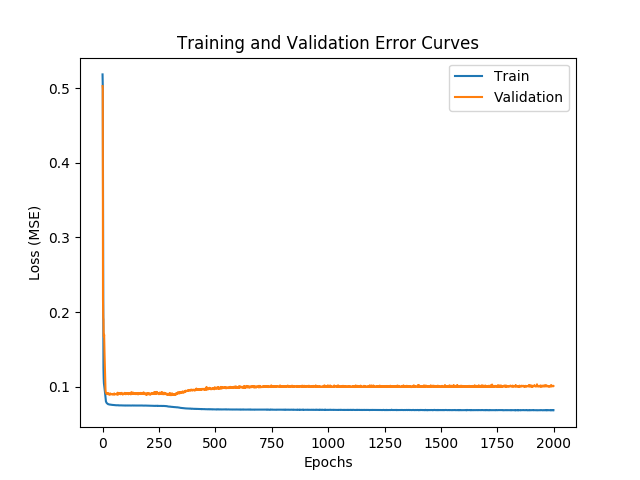

<IPython.core.display.Javascript object>


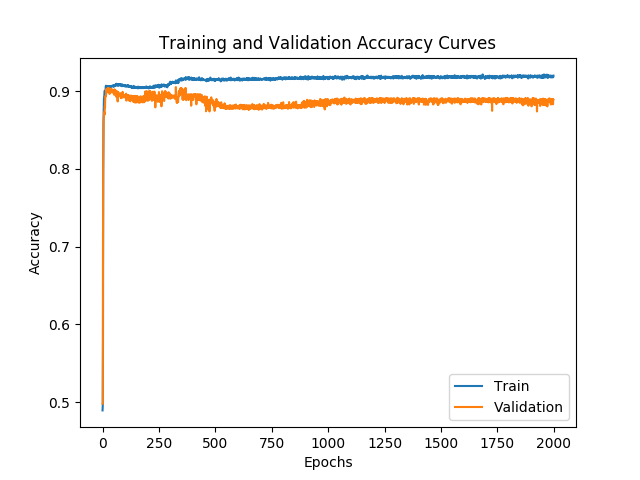

In [16]:
plot_training_error_curves(history)
plot_training_acc_curves(history)
# plot_training_roc_curves(y_test, X_test)

## RNA 2 (5)

In [109]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=100, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [110]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1120/1962 [================>.............] - ETA: 0s[0.051351102894963842, 0.93781855249745161]


<IPython.core.display.Javascript object>


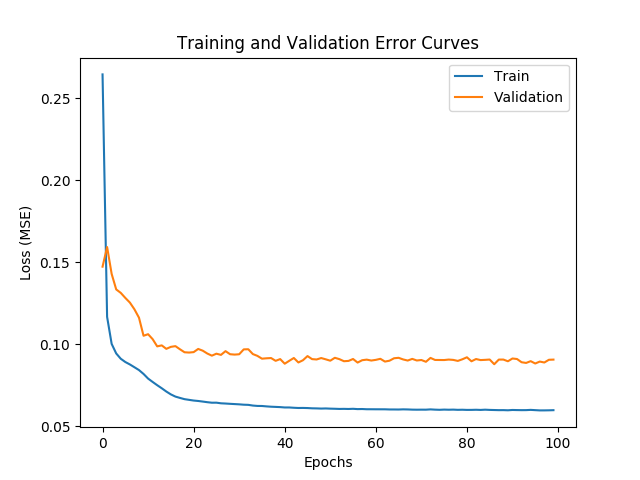

In [111]:
plot_training_error_curves(history)

## RNA 3 (3, 5)

In [112]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(3, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(5, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=100, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [113]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1952/1962 [============================>.] - ETA: 0s[0.061619813138554747, 0.92354740061162077]


<IPython.core.display.Javascript object>


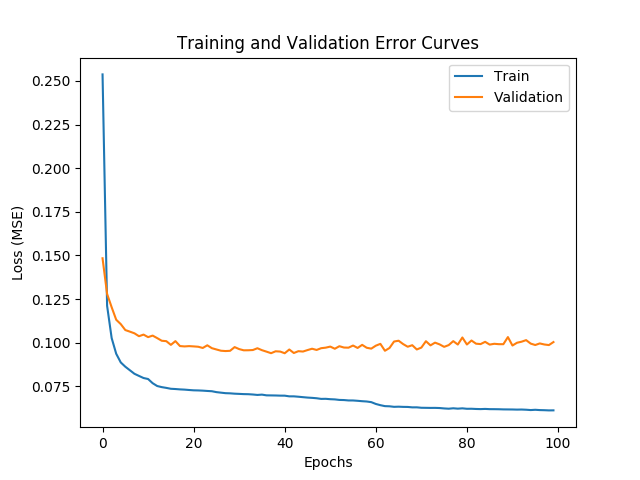

In [114]:
plot_training_error_curves(history)

## RNA 4 (5,3)

In [115]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(5, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(3, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=100, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [116]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1696/1962 [========================>.....] - ETA: 0s[0.060567798193593515, 0.90519877663689163]


<IPython.core.display.Javascript object>


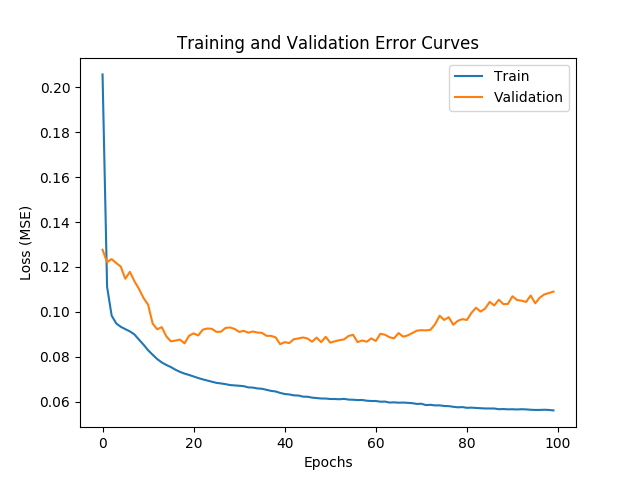

In [117]:
plot_training_error_curves(history)

## RNA 5 (4, 2)

In [118]:
# Aqui criamos o esboço da rede.
classifier = Sequential()

classifier.add(Dense(4, activation='relu', input_dim=6)) # camada escondida
classifier.add(Dense(2, activation='relu')) # camada escondida
classifier.add(Dense(1, activation='relu')) # 
classifier.compile(optimizer='adam', 
                   loss='mean_squared_error', # metrica de erro
                   metrics=['accuracy']) # metrica de sucesso

history = classifier.fit(X_train, y_train,
                         epochs=100, # quantidade de epocas que a rede neural vai executar
                         verbose=0,
                         shuffle=True, # utilizado para misturar as amostras a cada epoca
                         validation_data=(X_validation, y_validation))
#                          callbacks=[early_stopping], validation_data=(X_val, y_val))

In [119]:
test_loss = classifier.evaluate(X_test, y_test)
print (test_loss)

1504/1962 [=====================>........] - ETA: 0s[0.049759664944924648, 0.93221202854230378]


<IPython.core.display.Javascript object>


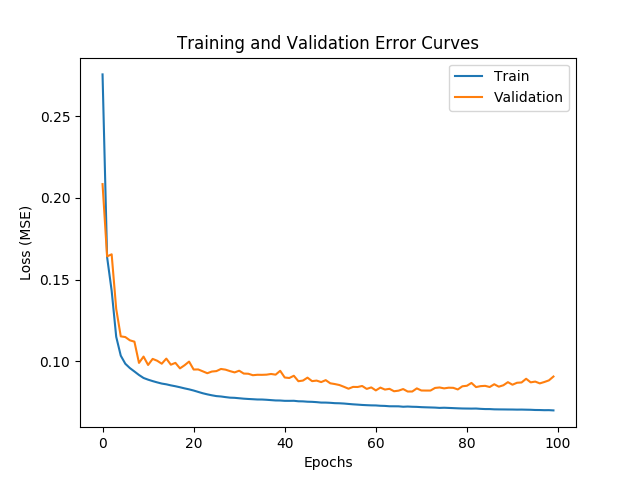

In [120]:
plot_training_error_curves(history)

## Predições no Conjunto de Teste

Agora utilizamos a nossa rede para fazer predições no conjunto de teste e computar métricas de desempenho.

Além das métricas utilizadas aqui, mais métricas de desempenho podem ser encontradas em: http://scikit-learn.org/stable/modules/classes.html#sklearn-metrics-metrics

In [121]:
## Fazer predições no conjunto de teste
y_pred = classifier.predict(X_test)
y_pred_class = classifier.predict_classes(X_test, verbose=0)

## Matriz de confusão
print('Matriz de confusão')
print(confusion_matrix(y_test, y_pred_class))

## Computar métricas de desempenho
losses = extract_final_losses(history)
print()
print("{metric:<18}{value:.4f}".format(metric="Train Loss:", value=losses['train_loss']))
print("{metric:<18}{value:.4f}".format(metric="Validation Loss:", value=losses['val_loss']))
print("{metric:<18}{value:.4f}".format(metric="Accuracy:", value=accuracy_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Recall:", value=recall_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="Precision:", value=precision_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="F1:", value=f1_score(y_test, y_pred_class)))
print("{metric:<18}{value:.4f}".format(metric="AUROC:", value=roc_auc_score(y_test, y_pred)))

Matriz de confusão
[[1774  124]
 [   9   55]]

Train Loss:       0.0725
Validation Loss:  0.0816
Accuracy:         0.9322
Recall:           0.8594
Precision:        0.3073
F1:               0.4527
AUROC:            0.9239
